# Tutorial 3: Análises de séries temporais com o `scipy` e o `Plotly`

### Importando as bibliotecas

In [41]:
# Importação das Bibliotecas necessárias para o trabalho
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
from matplotlib import cm
from scipy import stats
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

### Objetivos do Tutorial

Neste caderno você irá importar um arquivo de dados que está no repositório GitHub do LABOFIS e praticar o uso de várias ferramentas para examinar a série temporal. O arquivo possui informações de temperatura da Baía de Guanabara coletados na região da Ponte na profundidade de 05 metros e na Ilha Laje na profundidade de 20 metros. Você aprenderá a:

1. Carregar dados diretamente do GitHub
2. Plotar os dados com o pacote `Plotly`
3. Avaliar para inferir se a série é normal ou não
4. Usar o Filtro ButterWorth para calcular a baixa frequência dos dados

Após completar as tarefas acima, você deverá ser capaz de observar os eventos da Água Central do Atlântico Sul (ACAS) na Baía de Guanabara que se assemelha à figura abaixo. As regiões em azul correspondem às fases de de eventos de ACAS na Baía de Guanabara.

![Gráfico da ACAS na BG](https://raw.github.com/labofis/labofis_tutoriais/main/figures/sacw_in_GB.png)

Para mais informações sobre esse tema:

 - [Signorini, S. R. (1978). On the circulation and the volume transport of the Brazil Current between the Cape of São Tomé and Guanabara Bay. Deep Sea Research, 25(5), 481-490.](https://doi.org/10.1016/0146-6291(78)90556-8)

 - [Mariano, L. S., Cerrone, B. N., Fragoso, M. R., & Santos, N. G. (2012). Evidências de intrusão da Água Central do Atlântico Sul (ACAS) na Baía de Guanabara (RJ, Brasil). In Proceedings Congresso Brasileiro de Oceanografia (pp. 2221-2228).](http://projetobaiadeguanabara.com.br/producoes/Mariano_etal_CBO2012.pdf)

 - [Fernandes, A. M., Passos, E. N., Calil, P. H. R., Moser, G. A. O., de Oliveira, E. N., & Espíndola, R. P. (2023). Temperature stratification in the Guanabara Bay and its relationship with wind-induced coastal upwelling off Cabo Frio, Brazil. Estuarine, Coastal and Shelf Science, 291, 108433.](https://doi.org/10.1016/j.ecss.2023.108433)

  - [Passos, E., Sancho, L., Moser, G. A., Piedras, F. R., Espíndola, R. P., & Fernandes, A. M. (2023). South Atlantic Central Water Intrusion in the Southeast Brazil Bight and its impacts. Regional Studies in Marine Science, 67, 103232.]([https://doi.org/10.1016/j.rsma.2023.103232)


### Definindo funções

In [49]:
def basic_statistics(variavel1, variavel2):

  # mean
  print(' ')
  print('Variável 1 - Média: ', np.round(variavel1.mean(),3))
  print('Variável 2 - Média: ', np.round(variavel2.mean(),3))

  # median
  print(' ')
  print('Variável 1 - Mediana: ', np.round(variavel1.median(),3))
  print('Variável 2 - Mediana: ', np.round(variavel2.median(),3))

  # variance
  print(' ')
  print('Variável 1 - Variancia: ', np.round(variavel1.var(),3))
  print('Variável 2 - Variancia: ', np.round(variavel2.var(),3))


  # standard deviation
  print(' ')
  print('Variável 1 - Desvio Padrão: ', np.round(variavel1.std(),3))
  print('Variável 2 - Desvio Padrão: ', np.round(variavel2.std(),3))

  # Skewness
  print(' ')
  print('Variável 1 - Skewness: ', np.round(stats.skew(variavel1, nan_policy = 'omit'),3))
  print('Variável 2 - Skewness: ', np.round(stats.skew(variavel2, nan_policy = 'omit'),3))


In [43]:
# Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

### Seção 1: Carregando o dado diretamente do GitHub e avaliando se é uma distribuição normal

A distribuição normal, também conhecida como distribuição de Gauss, é uma das ideias mais importantes na estatística. Imagine um gráfico que parece um sino: essa é a forma da distribuição normal. Ela descreve como os dados tendem a se distribuir na maioria das situações do dia a dia.


Foi definida por Carl Friedrich Gauss, um matemático alemão do século XIX. Ele descobriu que muitos fenômenos naturais seguem esse padrão, como alturas de pessoas, notas em provas, ou até erros em medições.


Para entender se os seus dados seguem uma distribuição normal, você pode fazer um gráfico, chamado de histograma, que mostra como seus dados estão espalhados. Se o gráfico parecer com um sino, seus dados provavelmente seguem a distribuição normal, como podemor ver na figura abaixo. Outra forma de avaliar é usando testes estatísticos.


<img src="https://www.inf.ufsc.br/~andre.zibetti/probabilidade/figures/norm1-1.png" alt="Distribuição Normal" style="width: 50%;"/>

Crédito: [UFSC](https://www.inf.ufsc.br/~andre.zibetti/probabilidade/normal.html)

É importante saber se a distribuição da sua série é normal porque muitos métodos estatísticos se baseiam nela. Quando os dados seguem essa distribuição, fica mais fácil fazer previsões e tomar decisões. Por exemplo, ela ajuda a entender quais são as chances de algo acontecer, como prever a altura média de uma população ou calcular a probabilidade de um evento ocorrer.

Uma descrição mais completa de séries normais por ser encontrada [aqui](https://www.inf.ufsc.br/~andre.zibetti/probabilidade/normal.html).

Mas, antes de avaliar se é uma série normal ou não, temos que carregar o arquivo.

In [44]:
# Carregando o dado diretamente do repositório do GitHub
df = pd.read_csv('https://github.com/labofis/labofis_tutoriais/blob/main/serie_temepratura_bg.csv?raw=true', sep=',')

# Indexando pela data e hora
datas = [dt.datetime(df['Ano'][H], df['Mes'][H], df['Dia'][H], df['hora'][H], 0, 0) for H in range(0,len(df['Ano']))]
columns = [x for x in df]
df = df.drop([columns[0], columns[1], columns[2], columns[3]], axis='columns')
df.index = datas
df


T20 Laje  T05 Ponte
2014-10-27 00:00:00    18.794     22.944
2014-10-27 01:00:00    18.200     22.896
2014-10-27 02:00:00    17.915     21.963
2014-10-27 03:00:00    17.724     21.270
2014-10-27 04:00:00    17.915     20.007
...                       ...        ...
2016-05-04 20:00:00    21.342     21.604
2016-05-04 21:00:00    21.700     21.485
2016-05-04 22:00:00    21.700     21.366
2016-05-04 23:00:00    21.604     21.413
2016-05-05 00:00:00    21.724     21.151

[13345 rows x 2 columns]

#### Plotando as séries temporais para ter uma ideia de como é a temperatura

Para isso, vamos usar a biblioteca `Plotly`. O `Plotly` é uma biblioteca de visualização de dados interativa que permite criar gráficos de alta qualidade em Python (e em outras linguagens, como R e JavaScript). Ao contrário de outras bibliotecas como matplotlib e seaborn, o `Plotly` gera gráficos que são interativos, o que significa que você pode passar o mouse sobre os gráficos para ver detalhes, fazer zoom, e até mesmo exportar gráficos como imagens.

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datas,y=df['T05 Ponte'],name='Ponte 05 m'))
fig.add_trace(go.Scatter(x=datas,y=df['T20 Laje'],name='Ilha Laje 20 m'))
fig.show()

#### Histogramas das séries de temperatura para avaliar se são uma distribuição normal

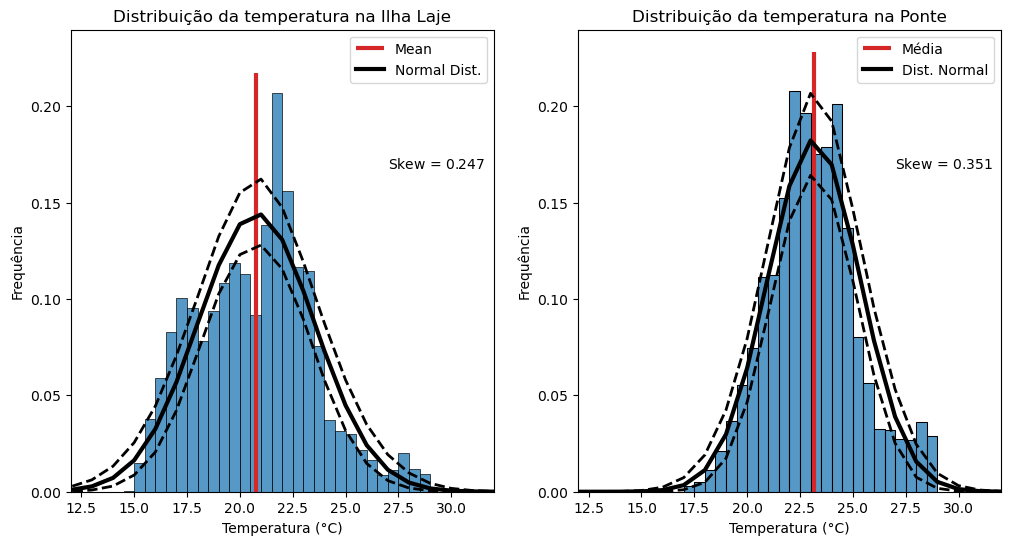

In [46]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)

temp_IL = df['T20 Laje']
x_r100 = np.arange(0, 100, 1)
skew = stats.skew(temp_IL, nan_policy = 'omit')

# take 1000 records of 100 samples
random_samples = np.random.normal(np.mean(temp_IL), np.std(temp_IL), size=[100, 1000])

# create placeholder for pdfs
pdfs = np.zeros([x_r100.size, 1000])

# loop through all 1000 records and create a pdf of each sample
for i in range(1000):
    # find pdfs
    pdfi = stats.norm.pdf(
        x_r100, random_samples[:, i].mean(), random_samples[:, i].std()
    )

    # add to array
    pdfs[:, i] = pdfi


bins = np.arange(0, np.max(temp_IL), .5)

# make histogram
_ = sns.histplot(temp_IL, bins=bins, stat="density", ax=ax)

# set x limits
_ = ax.set_xlim(12, 32)

# get y lims for plotting mean line
ylim = ax.get_ylim()

# add vertical line with mean
_ = ax.vlines(np.mean(temp_IL), ymin=ylim[0], ymax=ylim[1], color="C3", lw=3)

# plot pdf
_ = ax.plot(x_r100, stats.norm.pdf(x_r100, np.mean(temp_IL), np.std(temp_IL)), c="k", lw=3)

# plot 95th percentile
_ = ax.plot(x_r100, np.quantile(pdfs, 0.95, axis=1), "--", lw=2, color="k")

# plot 5th percentile
_ = ax.plot(x_r100, np.quantile(pdfs, 0.05, axis=1), "--", lw=2, color="k")

# set limits and labels
ax.set_xlim(12, 32)

ax.set_xlabel("Temperatura (°C)")
ax.set_ylabel("Frequência")
ax.set_title("Distribuição da temperatura na Ilha Laje")


ax.annotate(
    f"Skew = ${skew:0.3f}$",
    xy=(0.75, 0.70),
    xycoords='axes fraction'
)

# ax.legend(['Média', 'Dist. Normal'])
ax.legend(['Mean', 'Normal Dist.'])


# ax2 = fig.add_subplot(1, 2, 2)
ax2 = fig.add_subplot(1, 2, 2, sharey = ax, sharex = ax)

temp_Bd = df['T05 Ponte']
x_r100 = np.arange(0, 100, 1)
skew = stats.skew(temp_Bd, nan_policy = 'omit')

# take 1000 records of 100 samples
random_samples = np.random.normal(np.mean(temp_Bd), np.std(temp_Bd), size=[100, 1000])

# create placeholder for pdfs
pdfs = np.zeros([x_r100.size, 1000])

# loop through all 1000 records and create a pdf of each sample
for i in range(1000):
    # find pdfs
    pdfi = stats.norm.pdf(
        x_r100, random_samples[:, i].mean(), random_samples[:, i].std()
    )

    # add to array
    pdfs[:, i] = pdfi

bins = np.arange(0, np.max(temp_Bd), .5)

# make histogram
_ = sns.histplot(temp_Bd, bins=bins, stat="density", ax=ax2)

# set x limits
_ = ax2.set_xlim(12, 32)

# get y lims for plotting mean line
ylim = ax2.get_ylim()

# add vertical line with mean
_ = ax2.vlines(np.mean(temp_Bd), ymin=ylim[0], ymax=ylim[1], color="C3", lw=3)

# plot pdf
_ = ax2.plot(x_r100, stats.norm.pdf(x_r100, np.mean(temp_Bd), np.std(temp_Bd)), c="k", lw=3)

# plot 95th percentile
_ = ax2.plot(x_r100, np.quantile(pdfs, 0.95, axis=1), "--", lw=2, color="k")

# plot 5th percentile
_ = ax2.plot(x_r100, np.quantile(pdfs, 0.05, axis=1), "--", lw=2, color="k")

# set limits and labels
ax2.set_xlim(12, 32)


ax2.set_xlabel("Temperatura (°C)")
ax2.set_ylabel("Frequência")
ax2.set_title("Distribuição da temperatura na Ponte")


ax2.annotate(
    f"Skew = ${skew:0.3f}$",
    xy=(0.75, 0.70),
    xycoords='axes fraction'
)

ax2.legend(['Média', 'Dist. Normal'])


Também podemos avaliar as estatísticas básicas da nossa série. Para tal, construímos a função `basic_statistics` no início deste tutorial, que nos retorna informações sobre a média, mediana, desvio padrão, skewness, além de MSE, RMSE e RMA. Uma breve descrição é:

#### Média:
A média é a soma de todos os valores dividida pelo número total de valores. Ela representa o "centro de gravidade" dos dados e é usada para encontrar o valor típico ou central de uma série de dados.

**Fórmula:**

$\text{Média} = \frac{\sum_{i=1}^{n} x_i}{n}$

Onde $x_i$ são os valores da série de dados e \(n\) é o número total de valores.

**Exemplo de uso:** Se você tem as alturas de um grupo de pessoas, a média lhe dará a altura média do grupo.

#### Mediana:
A mediana é o valor que divide os dados em duas metades iguais quando os valores são organizados em ordem crescente. Se o número de valores for ímpar, a mediana é o valor do meio; se for par, é a média dos dois valores do meio.

**Exemplo de uso:** A mediana é particularmente útil em conjuntos de dados com valores extremos (outliers), pois não é afetada por esses valores tanto quanto a média.

#### Variância:
A variância mede o grau de dispersão dos dados em relação à média, ou seja, quão espalhados os valores estão. É a média dos quadrados das diferenças entre cada valor e a média.

**Fórmula:**

$\text{Variância} = \frac{\sum_{i=1}^{n} (x_i - \text{Média})^2}{n}$

**Exemplo de uso:** A variância é útil para entender a variabilidade dentro de um conjunto de dados. Quanto maior a variância, mais dispersos os dados estão.

#### Desvio Padrão:
O desvio padrão mede o quanto os valores de uma série de dados se desviam da média. É uma medida da dispersão ou variabilidade dos dados.

**Fórmula:**

$\text{Desvio Padrão} = \sqrt{\frac{\sum_{i=1}^{n} (x_i - \text{Média})^2}{n}}$

Onde $x_i$ são os valores da série de dados.

**Exemplo de uso:** Um desvio padrão baixo indica que os valores estão próximos da média, enquanto um desvio padrão alto indica que os valores estão espalhados em uma faixa mais ampla.

#### Skewness (Assimetria):
A skewness mede a simetria dos dados em torno da média. Se a skewness for zero, os dados são perfeitamente simétricos (o que é uma característica de uma distribuição normal). Valores positivos ou negativos indicam assimetria para a direita ou esquerda, respectivamente. Ou seja, o skewness é outra maneira de inferir se uma distribuição é normal ou não. A skewness mede a simetria dos dados em torno da média:

 - Skewness ≈ 0: A distribuição é simétrica, o que é uma característica da distribuição normal.
 - Skewness < 0: A distribuição é assimétrica à esquerda (cauda à esquerda é mais longa).
 - Skewness > 0: A distribuição é assimétrica à direita (cauda à direita é mais longa).

**Exemplo de uso:** A skewness é útil para identificar a tendência dos dados em se concentrar mais em um lado da média, o que pode influenciar a interpretação de resultados estatísticos.

In [50]:
# Algumas funções não aceitam séries com ausência de dados, então iremos apenas preencher os 
# valores vazios de ambas as séries com a respectiva média
df = df.fillna(df.mean())
basic_statistics(df['T20 Laje'], df['T05 Ponte'])

 
Variável 1 - Média:  20.772
Variável 2 - Média:  23.16
 
Variável 1 - Mediana:  21.008
Variável 2 - Mediana:  23.04
 
Variável 1 - Variancia:  7.626
Variável 2 - Variancia:  4.768
 
Variável 1 - Desvio Padrão:  2.762
Variável 2 - Desvio Padrão:  2.184
 
Variável 1 - Skewness:  0.247
Variável 2 - Skewness:  0.351
 
Erro médio quadrático:  3.092
Raiz do erro médio quadrático:  1.759
Media do erro absoluto:  2.438


Vamos interpretar os resultados das duas variáveis, levando em consideração as estatísticas calculadas. Lembre-se que a variável 1 é a série de temperatura da Ilha Laje em 20 metros de profundidade e a variável 2 é a série de temperatura para a Ponte em 5 metros de profundidade. Para as interpretações a seguir, iremos tratar apenas como Ponte e Ilha Laje.

A média da Ponte (23.16) é maior do que a média da Ilha Laje (20.772). Isso sugere que, em média, os valores da Ponte são mais altos do que os da Ilha Laje. No entanto, a diferença não é muito grande, o que indica que ambas as variáveis têm valores centrais relativamente próximos.

A mediana da Ilha Laje (21.008) é um pouco maior que a média, o que pode indicar uma leve assimetria à esquerda (se a distribuição fosse exatamente simétrica, a média e a mediana seriam iguais ou muito próximas). Para a Ponte, a mediana (23.04) é ligeiramente menor que a média, sugerindo uma leve assimetria à direita.

A Ilha Laje tem uma variância e um desvio padrão maiores do que a Ponte. Isso indica que os valores da Ilha Laje estão mais dispersos em torno da média, ou seja, há mais variabilidade nos dados da Ilha Laje. A Ponte, por outro lado, apresenta menos dispersão, sugerindo que os valores estão mais concentrados em torno da média.

Ambas as variáveis têm um valor de skewness positivo, o que indica uma leve assimetria à direita, ou seja, as caudas à direita das distribuições são um pouco mais longas (o que podemos observar nos histogramas acima). No entanto, os valores de skewness estão próximos de 0, sugerindo que as distribuições são relativamente simétricas e podem estar próximas de uma distribuição normal.



**Em resumo:**

- **Ponte** tem uma média mais alta e uma menor dispersão que a **Ilha Laje**, indicando que seus valores são, em média, maiores, mas menos variáveis.
- Ambas as variáveis têm distribuições levemente assimétricas à direita, mas próximas da simetria.



### Seção 2: Filtrando séries temporaias 

Séries temporais são sequências de dados coletados ou registrados ao longo do tempo, e são comuns em diversos campos, desde finanças e economia, como engenharia, meteorologia e oceanografia . Ao analisar esses dados, muitas vezes é necessário filtrar a série temporal para remover ruídos, destacar tendências ou isolar componentes específicos da série. A filtragem de séries temporais é um processo essencial que permite melhorar a qualidade dos dados e extrair informações mais significativas.


- **Remoção de Ruídos:** Muitas séries temporais contêm ruídos — flutuações aleatórias e indesejadas que podem obscurecer as informações relevantes. Filtrar a série ajuda a remover esses ruídos, tornando os padrões e tendências mais claros.
- **Destacar Tendências:** Em uma série temporal, as tendências são padrões de longo prazo que mostram o comportamento geral dos dados ao longo do tempo. A filtragem ajuda a isolar essas tendências, facilitando sua análise.
- **Isolar Componentes Específicos:** As séries temporais podem ser compostas por diferentes componentes, como tendência, sazonalidade e ruído. A filtragem permite isolar esses componentes para uma análise mais focada.
- **Preparação para Modelagem:** Antes de aplicar modelos estatísticos ou de machine learning, é importante preparar os dados adequadamente. A filtragem pode ser uma etapa crucial nesse processo, garantindo que os dados estejam livres de ruídos e prontos para a modelagem.


Dessa forma, podemos considerar que a importância da filtragem de séries temporais é:
- **Melhor Previsão:** Ao remover ruídos e destacar tendências, a filtragem melhora a precisão das previsões feitas a partir de séries temporais.
- **Detecção de Anomalias:** Filtrando ruídos e flutuações indesejadas, é mais fácil detectar anomalias reais nos dados, como quedas abruptas ou picos inesperados, que podem indicar eventos significativos.
- **Análise de Ciclos e Sazonalidade:** Muitos fenômenos naturais têm ciclos regulares ou padrões sazonais. A filtragem pode isolar esses ciclos, facilitando a análise e a tomada de decisões baseadas neles.
- **Clareza na Visualização:** Dados filtrados são geralmente mais fáceis de visualizar e interpretar, especialmente em gráficos e outras representações visuais.

##### **Filtro Butterworth**

O Filtro Butterworth é uma técnica de filtragem comumente usada para suavizar séries temporais, eliminando ruídos de alta frequência enquanto preserva a integridade do sinal principal. Ele foi desenvolvido por Stephen Butterworth em 1930 e é amplamente utilizado devido à sua eficácia e simplicidade. Este filtro é importante porque oferece um equilíbrio entre simplicidade e eficácia. Ele suaviza dados de forma eficaz, sem introduzir distorções significativas, tornando-o ideal para aplicações onde é necessário preservar o máximo de informações úteis enquanto se remove ruído.


##### **Características do Filtro Butterworth:**
O filtro Butterworth é conhecido por sua resposta em frequência suave e monotônica, o que significa que ele não tem ondulações na banda passante e rejeita eficientemente as frequências indesejadas. Além disso, a ordem do filtro Butterworth determina sua eficácia. Um filtro de ordem mais alta terá uma atenuação mais acentuada das frequências indesejadas, mas pode introduzir maior atraso de fase.

O filtro Butterworth é versátil e pode ser configurado de diferentes maneiras para atender a necessidades específicas na análise de séries temporais.

 - **Filtro Passa-Baixa Butterworth:** Excelente para eliminar ruídos e focar em tendências, sendo útil quando o objetivo é analisar o comportamento geral de longo prazo de uma série temporal. Este filtro Permite que as frequências baixas passem e atenua (ou elimina) as frequências altas.É utilizado para remover ruídos de alta frequência e suavizar os dados, preservando as tendências de longo prazo e os ciclos lentos na série temporal.

 - **Filtro Passa-Alta Butterworth:** Ideal para identificar e analisar mudanças rápidas ou padrões de alta frequência, como flutuações de curto prazo, permitindo insights sobre eventos que podem ser perdidos ao observar apenas as tendências gerais. Este filtro faz o oposto do filtro passa-baixa, permitindo que apenas as frequências altas passem e atenuando as frequências baixas. É utilizado para destacar mudanças rápidas ou variações de curto prazo em uma série temporal, eliminando as tendências de longo prazo.

 - **Filtro Passa-Banda Butterworth:** Permite uma análise focada em ciclos específicos, o que é crucial em situações onde padrões sazonais ou cíclicos são de interesse particular, e onde é importante separar essas flutuações dos outros componentes da série temporal. Este filtro permite que apenas uma faixa específica de frequências passe, atenuando tanto as frequências abaixo quanto as acima dessa faixa. É ideal para isolar ciclos específicos dentro de uma série temporal, como padrões sazonais ou cíclicos que ocorrem em uma faixa de frequência específica.


Text(0.5, 1.0, 'Ilha Laje')

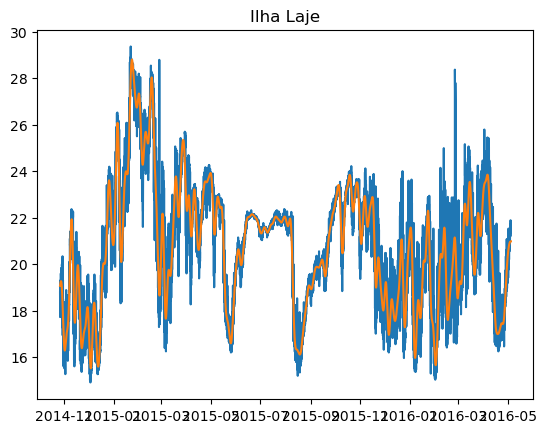

In [54]:
# Aplicando o filtro
# O primeiro valor (df['T20 Laje']) é a sua série
# O segundo valor (1/72) indica que o corte é em 72h
# O terceiro valor (1) é a frequência de Nyquist e estabelece o limite superior de frequências que 
# podem ser processadas corretamente em um sinal amostrado digitalmente
# O quarto e último valor é optativo e corresponde a ordem do filtro. O valor default é 4.
data = butter_lowpass_filter(df['T20 Laje'],1/72,1)

# Adicionando no nosso dataframe
df['Laje Filtrado'] = data

# Plotando as duas séries para comparação
plt.plot(df.index, df['T20 Laje'])
plt.plot(df.index, data)
plt.title('Ilha Laje')


Text(0.5, 1.0, 'Ponte')

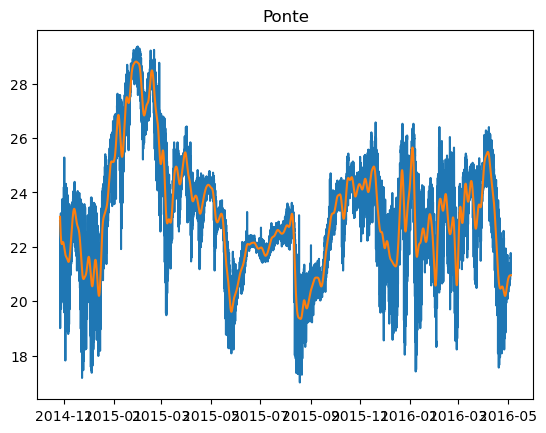

In [56]:
# Aplicando o filtro
data = butter_lowpass_filter(df['T05 Ponte'],1/72,1)

# Adicionando no nosso dataframe
df['Ponte Filtrado'] = data

# Plotando as duas séries para comparação
plt.plot(df.index, df['T05 Ponte'])
plt.plot(df.index, data)
plt.title('Ponte')

In [57]:
df

T20 Laje  T05 Ponte  Laje Filtrado  Ponte Filtrado
2014-10-27 00:00:00    18.794     22.944      19.070590       23.101526
2014-10-27 01:00:00    18.200     22.896      19.080852       23.064818
2014-10-27 02:00:00    17.915     21.963      19.091081       23.028502
2014-10-27 03:00:00    17.724     21.270      19.101255       22.992609
2014-10-27 04:00:00    17.915     20.007      19.111357       22.957171
...                       ...        ...            ...             ...
2016-05-04 20:00:00    21.342     21.604      20.981542       20.953555
2016-05-04 21:00:00    21.700     21.485      20.981703       20.953598
2016-05-04 22:00:00    21.700     21.366      20.981835       20.953633
2016-05-04 23:00:00    21.604     21.413      20.981942       20.953661
2016-05-05 00:00:00    21.724     21.151      20.982028       20.953684

[13345 rows x 4 columns]

Refazendo a figura com o `Plotly`

In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datas,y=df['Ponte Filtrado'],name='Ponte'))
fig.add_trace(go.Scatter(x=datas,y=df['Laje Filtrado'],name='Ilha Laje'))
fig.show()

Agora, vamos analisar brevemente como é a correlação do nosso dataframe:

In [60]:
df.corr()

T20 Laje  T05 Ponte  Laje Filtrado  Ponte Filtrado
T20 Laje        1.000000   0.707406       0.956758        0.744727
T05 Ponte       0.707406   1.000000       0.722466        0.918379
Laje Filtrado   0.956758   0.722466       1.000000        0.785983
Ponte Filtrado  0.744727   0.918379       0.785983        1.000000

Observamos que a correlação entre as séries aumentou após a aplicação do filtro. Isso indica que os componentes de baixa frequência (tendências de longo prazo e ciclos mais lentos) têm uma maior correlação entre as duas séries em comparação com os componentes de alta frequência (ruídos e flutuações rápidas).

Essa melhora na correlação sugere que, ao remover as frequências altas, que geralmente representam ruídos e variações aleatórias, conseguimos destacar a relação subjacente entre as séries, que é mais estável e consistente ao longo do tempo. Portanto, a filtragem permite uma análise mais precisa das interdependências entre as séries temporais, focando nos componentes que carregam a informação mais relevante para o contexto estudado.

Por fim, vamos elaborar a figura do início do nosso tutorial:

(14.0, 30.0)

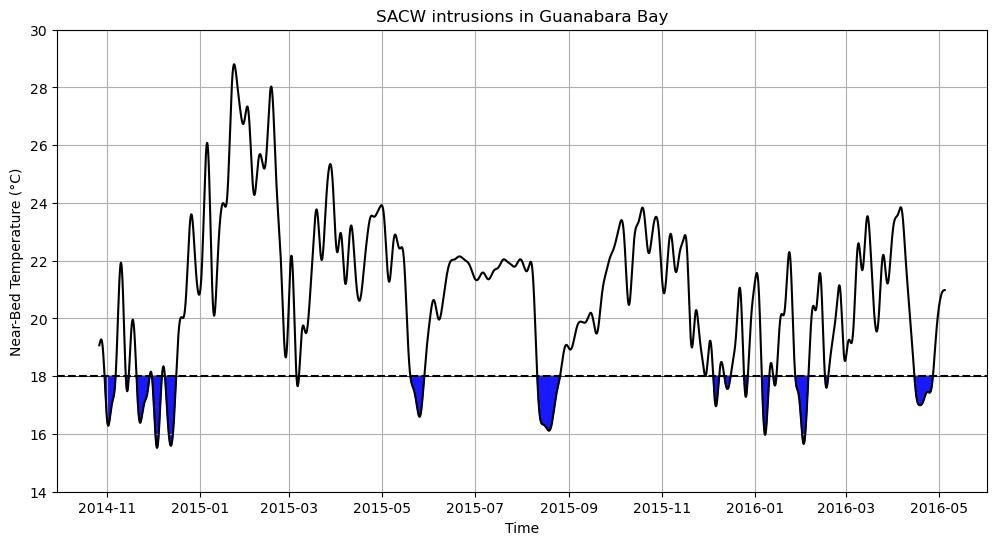

In [61]:
serie_filtrada_laje = df['Laje Filtrado']
time = datas

%matplotlib inline
# Adding labels and a grid
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)

# Plot the series of data
ax.plot(time, serie_filtrada_laje, label='T_{NB}', color="black")
ax.set_xlabel('Time')
ax.set_ylabel('Near-Bed Temperature (°C)')
ax.set_title('SACW intrusions in Guanabara Bay')

ax.axhline(18, color="black", lw=0.5)  # add a black line at x=0
ax.axhline(
    18, color="black", linewidth=1.5, linestyle="dashed"
)  # add a black line at x=-0.5
ax.grid(True)

plt.fill_between(  # plot with color in between
    time,  # x values
    # top boundary - y values below 0.5
    serie_filtrada_laje.where(serie_filtrada_laje <= 18),
    18,  # bottom boundary - -0.5
    color="blue",  # color
    alpha=0.9,  # transparency value_mean_mean_mean_mean_mean
)


# Adiciona formatação de data ao eixo x
ax.xaxis_date()
ax.set_ylim([14, 30])

### Desafio:

Faça essa mesma figura para a série da Ponte filtrada

In [ ]:
serie_filtrada = ...
time = ...

%matplotlib inline
# Adding labels and a grid
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)

# Plot the series of data
ax.plot(
    ...
    )
